<a href="https://colab.research.google.com/github/Mattshanevdberg/ML-FruitPunchAI_BootCamp/blob/main/4_1_Detecting_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

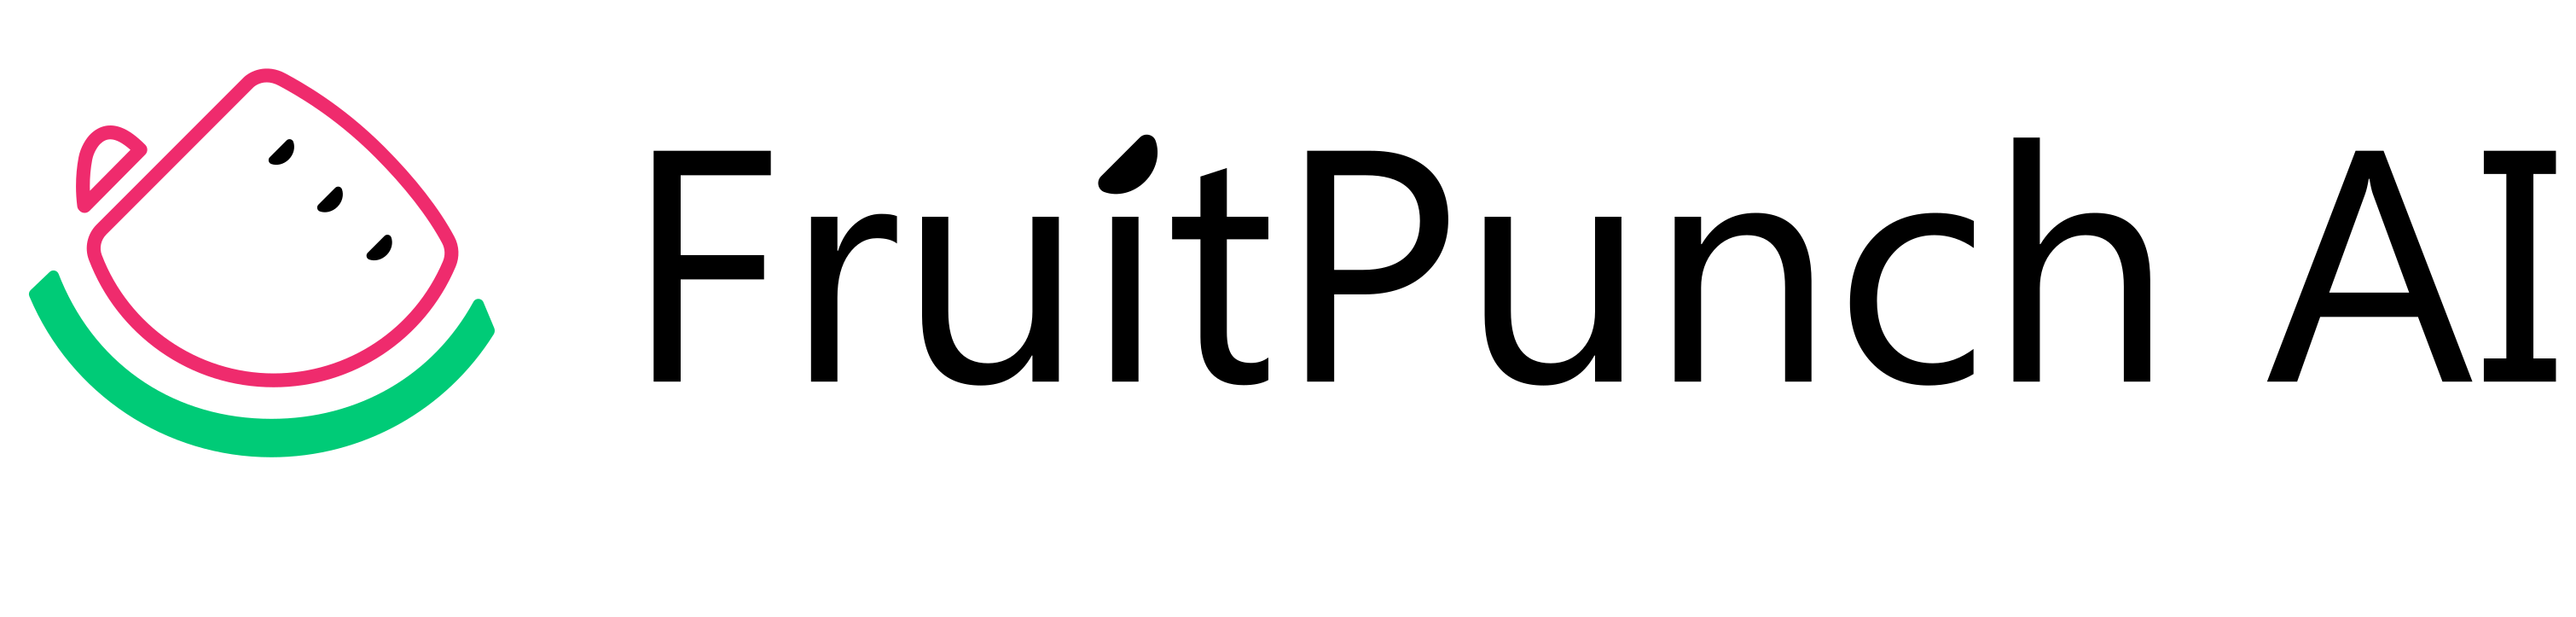

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gdown

In [2]:
v = 5

In [3]:
print(v)

5


###Make sure that your notebook is running on GPU since we will be handeling some pretty hefty algoritms. You can change the notebook setting via Edit>Notebook settings>Hardware accelerator>GPU

# Pittfalls of working with image data 

We will go over some of the most common pittfalls and biases in machine learning. To do this we will make use of the COVID-19 Radiography Database from kaggle: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database 

For computational reasons we made a subset for you to work with. Of each categorie we took 1000 images for the train set and 200 for the test set.

The goal of this assignment is to make you aware of the potential risks that hide in working with image data. And escpecially open source data. 

First of all let's start this session by taking a good look at the data set. Open the link and see if you can find any notable things. 

Maybe you can already find some interesting things. Maybe not, let's take a closer look at the individual images. 

In [4]:
#https://drive.google.com/file/d/1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H/view?usp=sharing 
!gdown --id 1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H

#https://drive.google.com/file/d/1AxIOLcraa5CuIp0x22WrC9gTPILaVt46/view?usp=sharing
!gdown --id 1AxIOLcraa5CuIp0x22WrC9gTPILaVt46

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser

In [5]:
file_id = "1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
file_id = "1AxIOLcraa5CuIp0x22WrC9gTPILaVt46"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H
To: /content/train_dataset.npz
100%|██████████| 236M/236M [00:00<00:00, 305MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1AxIOLcraa5CuIp0x22WrC9gTPILaVt46
To: /content/test_dataset.npz
100%|██████████| 47.1M/47.1M [00:00<00:00, 256MB/s]


'test_dataset.npz'

In [6]:
from numpy import load

# First lets see what we're working with

train = load('/content/train_dataset.npz')
test = load('/content/test_dataset.npz')

x_train, y_train = train['arr_0'], train['arr_1']
x_test, y_test = test['arr_0'], test['arr_1']

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#print(y_train[2500:3900])

(4000, 256, 256, 3) (4000,) (800, 256, 256, 3) (800,)


label: 1


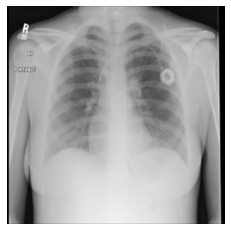

In [7]:
from matplotlib import pyplot

idx = 1500   # Change this number to see other images
pyplot.axis('off')
pyplot.imshow(x_train[idx], cmap='gray')
print("label:",y_train[idx])

# 0 = viral pneumonia (images train: 0-999      test: 0-199)
# 1 = normal          (images train: 1000-1999  test: 200-399)
# 2 = lung opacity    (images train: 2000-2999  test: 400-599)
# 3 = covid           (images train: 3000-3999  test: 600-799)

## **Assignment 1**
A) Define what is the signal and what is the noise in this dataset.

B) Name 3 types of noise you can find in the images.

C) By looking at the images, can you predict if a Convolutional Neural Network will overfit? And what do you need to look at to predict this.

D) What can you say about train/test leakage in this dataset?

In [8]:
# write down your answers

A) the signal is the part of the image within the lung area of the image. Specifically the gaps in that area between the ribs and either side of the sternum

B)  1. The area outside of the lungs
2. any writing on the X-ray (symbols in the top right or left)
3. any medical devices in the images (pacemakers, wires, etc)

C) No, to check overfitting you can look at the preformance on the training set vs the test set, if the performance is far better on the training set than the test set, there is likely some form of overfitting

D)There is likely to be train, test set leakage as patients could have had multiple scans and one could have ended up in the test set and one in the train set. A way to ensure this does not happen/is minimalised is to the test and training sets come from different areas/hospitals


## Let's put this to the test

In the next part we will use transfer learning to train a ResNet50 on our data. For now it is not important to fully understand what a ResNet is. It basicly is a very large CNN, trained on millions of images. This ensures that the network is already able to recognize certain patterns. In the next chapter we will dive deeper into the world of transfer learning.  

In [18]:
# Run the following cells to train your ResNet, and evaluate it on the test set. (This may take 3-5 minutes, so grab yourself a nice coffee or a snack ;)
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers

# Loading the ResNet-50 model, removing the toplayers and keeping the rest of the pre-trained layers frozen.

res = ResNet50(include_top=False, weights='imagenet' ,input_shape=(256, 256, 3))

intermediate_model = Model(inputs=res.input, outputs=res.layers[130].output)

for layer in intermediate_model.layers:
  layer.trainable = False

x = Flatten()(intermediate_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
pred = Dense(4, activation='softmax')(x)

model = keras.Model(intermediate_model.input, pred)


# summarize the model, you can check this out if your interested in the model architecture of the ResNet50
#model.summary()

In [19]:
print(len(res.layers))
print(len(model.layers))

175
136


In [20]:

# summarize the model, you can check this out if your interested in the model architecture of the ResNet50
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [21]:
# Compile model 
adam = optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [22]:
# train model
with tf.device('/device:GPU:0'):  
  model.fit(
    x = x_train,
    y = y_train,
    batch_size = 20,
    validation_split = 0.1,
    epochs = 10,
    verbose = 1)

Epoch 1/10
180/180 [==============================] - 20s 98ms/step - loss: 11.3087 - accuracy: 0.6664 - val_loss: 0.8712 - val_accuracy: 0.7725
Epoch 2/10
180/180 [==============================] - 17s 92ms/step - loss: 0.8291 - accuracy: 0.6356 - val_loss: 1.6546 - val_accuracy: 0.0725
Epoch 3/10
180/180 [==============================] - 15s 84ms/step - loss: 0.6931 - accuracy: 0.7308 - val_loss: 0.8521 - val_accuracy: 0.7050
Epoch 4/10
180/180 [==============================] - 15s 84ms/step - loss: 0.5868 - accuracy: 0.7653 - val_loss: 0.9530 - val_accuracy: 0.5775
Epoch 5/10
180/180 [==============================] - 15s 84ms/step - loss: 0.5330 - accuracy: 0.7800 - val_loss: 1.3053 - val_accuracy: 0.3725
Epoch 6/10
180/180 [==============================] - 15s 85ms/step - loss: 0.4715 - accuracy: 0.8197 - val_loss: 0.5619 - val_accuracy: 0.8300
Epoch 7/10
180/180 [==============================] - 15s 85ms/step - loss: 0.5861 - accuracy: 0.7767 - val_loss: 0.3302 - val_accuracy

In [23]:
from sklearn.metrics import classification_report

# Lets evaluate our model

pred = model.predict(x_test)
pred = pred.argmax(axis=1)
print(classification_report(y_test, pred))

25/25 [==============================] - 3s 94ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.53      0.98      0.69       200
           2       0.97      0.28      0.43       200
           3       0.96      0.82      0.89       200

    accuracy                           0.77       800
   macro avg       0.86      0.77      0.75       800
weighted avg       0.86      0.77      0.75       800



If everything went right your model reached an accuracy of ~90%. Pretty good right? But how do you know if your model is actually picking up the right signals?

To test the generalizability of your model it is important to test it on new data. Luckily there are plenty of Covid radiographic datasets out there. Load in the next test set and see how well you model can predict this. **Note:** This new dataset only consists of covid positive and normal lungs

In [15]:
# load in the new dataset
!gdown --id 1-93bATdMTC3QnUrJPPWxKm1Q2SjApefN

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-93bATdMTC3QnUrJPPWxKm1Q2SjApefN
To: /content/test_covid.npz
100% 22.3M/22.3M [00:00<00:00, 58.5MB/s]


In [16]:
# Create a new test set and check shape
new_test = load('/content/test_covid.npz')

new_x_test, new_y_test = new_test['arr_0'], new_test['arr_1']

new_x_test.shape, new_y_test.shape

((400, 256, 256, 3), (400,))

In [24]:
# Predict labels for new data
new_pred = model.predict(new_x_test)
new_pred = new_pred.argmax(axis=1)
print(np.bincount(new_pred))
print(classification_report(new_y_test, new_pred, zero_division=True))

13/13 [==============================] - 2s 104ms/step
[  0 255  34 111]
              precision    recall  f1-score   support

           1       0.64      0.82      0.72       200
           2       0.00      1.00      0.00         0
           3       0.98      0.55      0.70       200

    accuracy                           0.68       400
   macro avg       0.54      0.79      0.47       400
weighted avg       0.81      0.68      0.71       400



##original:


13/13 [==============================] - 3s 176ms/step
[  1 158 166  75]
              
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.52      0.41      0.46       200
           2       0.00      1.00      0.00         0
           3       0.95      0.35      0.52       200
    accuracy          0        0       0.38       400

   macro avg       0.37      0.69      0.24       400

weighted avg       0.73      0.38      0.49       400

##orginal v2:
13/13 [==============================] - 3s 171ms/step
[  0 150 131 119]
              precision    recall  f1-score   support

           1       0.63      0.47      0.54       200
           2       0.00      1.00      0.00         0
           3       0.93      0.56      0.70       200

    accuracy                           0.52       400
   macro avg       0.52      0.68      0.41       400
weighted avg       0.78      0.52      0.62       400

##with only 80 layers:

13/13 [==============================] - 1s 77ms/step
[  0 400]
              precision    recall  f1-score   support

           1       0.50      1.00      0.67       200
           3       1.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.75      0.50      0.33       400
weighted avg       0.75      0.50      0.33       400

So a bit higher BUT not great BUT this is almost the same as the accuracy on the training set.

##with 130 layers:
###on train data:
25/25 [==============================] - 3s 94ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.53      0.98      0.69       200
           2       0.97      0.28      0.43       200
           3       0.96      0.82      0.89       200

    accuracy                           0.77       800
   macro avg       0.86      0.77      0.75       800
weighted avg       0.86      0.77      0.75       800
###on test data:
13/13 [==============================] - 2s 104ms/step
[  0 255  34 111]
              precision    recall  f1-score   support

           1       0.64      0.82      0.72       200
           2       0.00      1.00      0.00         0
           3       0.98      0.55      0.70       200

    accuracy                           0.68       400
   macro avg       0.54      0.79      0.47       400
weighted avg       0.81      0.68      0.71       400

## **Assignment 2**

A) Do you recognize any signs of overfitting in the accuracy values?

B) What does the test accuracy indicate about overfitting?

C) Try to change some parameters, add/remove layers and see how this effects the accuracy values.

D) Try to look up how accurate trained radiologists are able to classify COVID-19 patients. And compare this to the outcome of our model.

E) Do you notice anything remarkable?

A) Yes the accuracy is very low for the new dataset. This shows that the algorithm is great on the training set but on the general data (new data) it is not doing well

B) If test accuracy is much lower than training, there is likely overfitting.

C) made less layers - lowered the accuracy on the training set but on the test set accuracy had a slight improvement

D)
<i>Chest X-ray: suspected people

Pooled results showed that chest X-ray (17 studies) correctly diagnosed COVID-19 in 73 % of people who had COVID-19. However, it incorrectly identified COVID-19 in 27% of people who did not have COVID-19.</i>

E) we cannot acheive the kind of accuracy that human can acheive


Now that we now our model is overfitting we want to know why. To get insight in our model we will generate some heatmaps, also called saliency maps, to see if that can help us find the noise.

There are multiple ways to do this. We will demonstrate by the hand of [XRAI](https://arxiv.org/pdf/1906.02825.pdf). Saliency methods link a deep neural network's (DNN) prediction to the input features that most influence that prediction. If the model makes a misprediction, we want to know which features contributed to the misclassification. We can visualize the saliency map for image models with the same dimensions as the original image with brightness corresponding to the importance of the pixel. 

XRAI identifies salient regions. The algorithm uses a pixel-level attribution method such as Integrated Gradients or Guided IG as well as segmentation maps, and then identifies important regions by summing attributions as segments.

In [25]:
!pip install saliency tensorflow -q

     |████████████████████████████████| 86 kB 5.1 MB/s 


In [26]:
from matplotlib import pylab as P
class_idx_str = 'class_idx_str'

def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im

Prediction class: 3


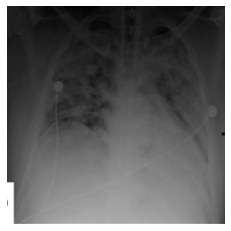

In [27]:
# Select an image that you want to use 
img_id = 3003

im = x_train[img_id]
ShowImage(im)
prediction_class = y_train[img_id]
#prediction = model(np.array([im]))
#if prediction[0] >= 0.5:
#  prediction_class = 1
#else:
#  prediction_class = 0  
call_model_args = {class_idx_str: prediction_class}
print("Prediction class: " + str(prediction_class))

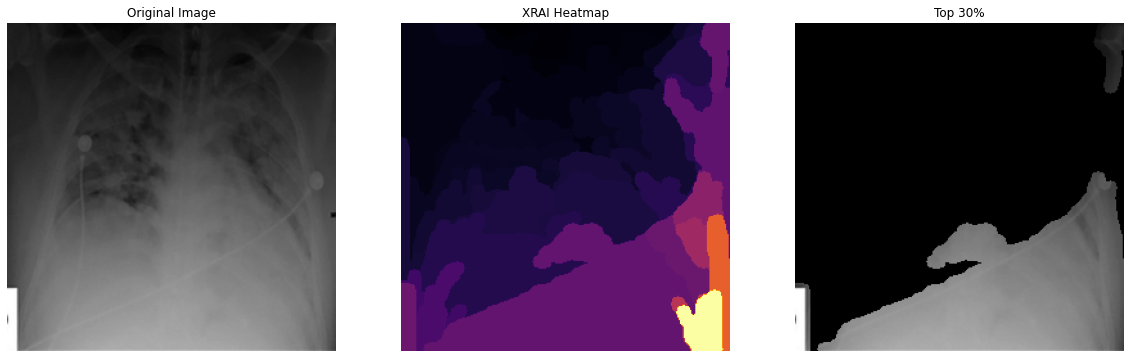

In [28]:
import saliency.core as saliency
with tf.device('/device:GPU:0'):
    # Construct the saliency object. This alone doesn't do anthing.
  xrai_object = saliency.XRAI()

  # Compute XRAI attributions with default parameters
  xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=4)

  # Set up matplot lib figures.
  ROWS = 1
  COLS = 3
  UPSCALE_FACTOR = 20
  P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

  # Show original image
  ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

  # Show XRAI heatmap attributions
  ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

  # Show most salient x% of the image
  mask = xrai_attributions > np.percentile(xrai_attributions, 70)
  im_mask = np.array(im)
  im_mask[~mask] = 0
  ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

# **Assignment 3**

Generate saliency maps for a couple of images and determine which features are picked up as noise and which are signal.

Prediction class: 3
Prediction class: 3
Prediction class: 3
Prediction class: 3


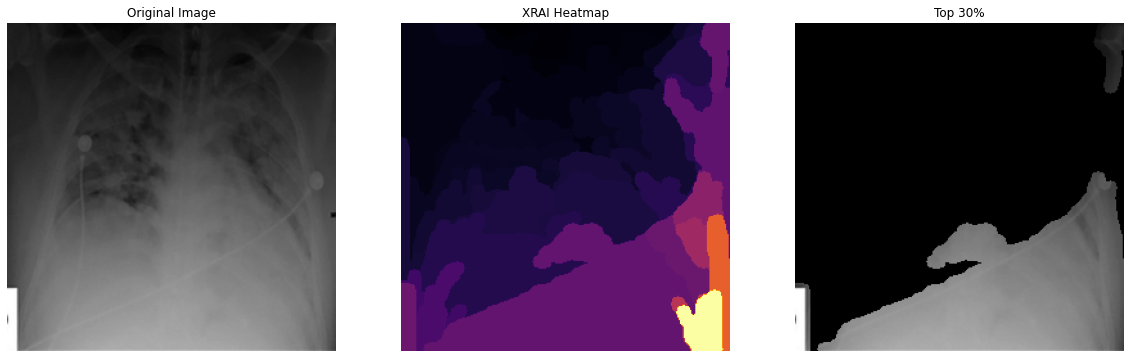

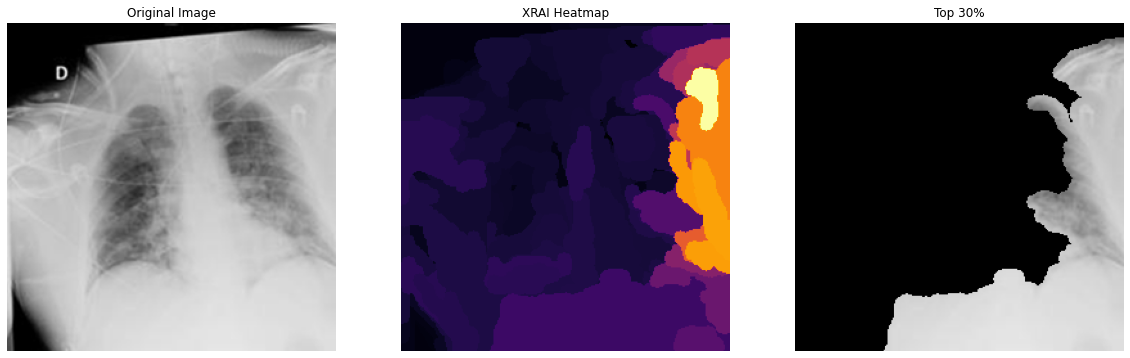

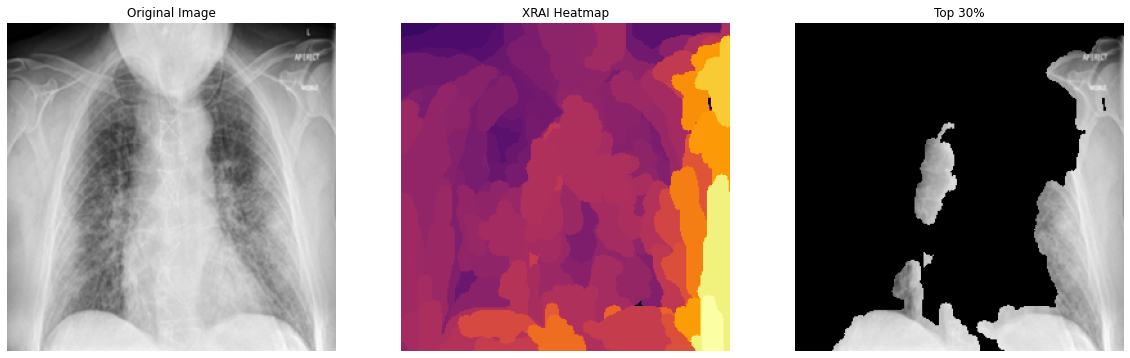

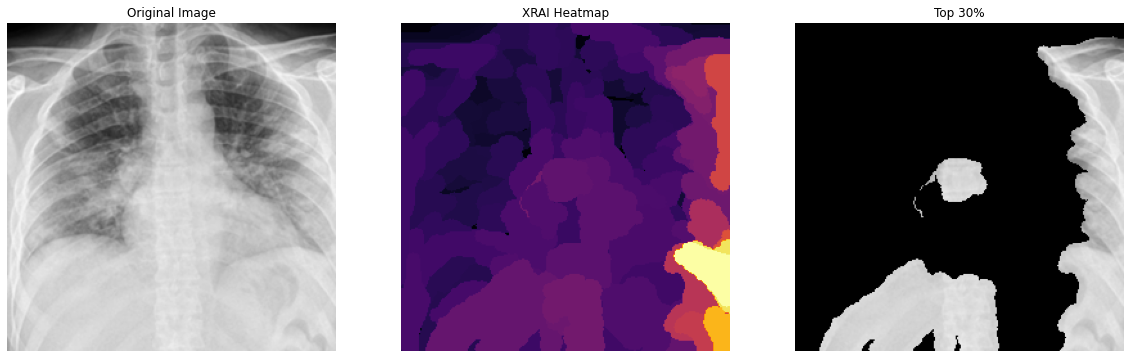

In [34]:
# Select an image that you want to use 
import saliency.core as saliency
img_id_list = [3003, 3006, 3010, 3030] 
for img_id in img_id_list:
  im = x_train[img_id]
  #ShowImage(im)
  prediction_class = y_train[img_id]
  #prediction = model(np.array([im]))
  #if prediction[0] >= 0.5:
  #  prediction_class = 1
  #else:
  #  prediction_class = 0  
  call_model_args = {class_idx_str: prediction_class}
  print("Prediction class: " + str(prediction_class))


  with tf.device('/device:GPU:0'):
      # Construct the saliency object. This alone doesn't do anthing.
    xrai_object = saliency.XRAI()

    # Compute XRAI attributions with default parameters
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=4)

    # Set up matplot lib figures.
    ROWS = 1
    COLS = 3
    UPSCALE_FACTOR = 20
    P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

    # Show original image
    ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

    # Show XRAI heatmap attributions
    ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

    # Show most salient x% of the image
    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im)
    im_mask[~mask] = 0
    ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))